### Entranamiento / Evaluación

In [365]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


#### 💪 Training

In [366]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [367]:
proc_data_path='../data/processed/road_traffic_accidents_dataset_proc.csv'
train_data = pd.read_csv(proc_data_path)


In [368]:
x = train_data.drop('accident_severity', axis=1)
y = train_data['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [369]:
models={"LogisticRegression":LogisticRegression(max_iter=1000),
        "DecisionTreeClassifier":DecisionTreeClassifier(),
        "KNeighborsClassifier":KNeighborsClassifier(),
        "RandomForestClassifier":RandomForestClassifier(),
        # "AdaBoostClassifier":AdaBoostClassifier(),
        # "GradientBoostingClassifier":GradientBoostingClassifier(),
        }

In [370]:
# models,x,y,scaleFlag=0,1,2
def modelAccuracy(models,x,y,scaleFlag):
    #train/Test
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
    acc_result={}
    for name,model in models.items():
        #pipeline
        #1.Transformer -> 2.Model
        if(scaleFlag==1):
            model_pipeline=Pipeline([('MinMaxScler',MinMaxScaler()),('model',model)])
        elif(scaleFlag==2):
             model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])
        else:
            model_pipeline=Pipeline([('model',model)])
        #training/testing on model pipeline
        model_fit=model_pipeline.fit(xtrain,ytrain)
        ypred=model_fit.predict(xtest)
        acc=accuracy_score(ytest,ypred)
        print("The Accuracy for ",name," is :",acc)
        acc_result[name]=acc
    return acc_result

In [371]:
def bestModel(result):
    high=0
    for name,acc in result.items():
        if acc>high:
            high=acc
            model_name=name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [372]:
def bestParams(model,param,xtrain,ytrain):
    #cv
    cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="f1_weighted")
    res=grid_cv.fit(xtrain,ytrain)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)

In [373]:
acc_result=modelAccuracy(models,x,y,0)

The Accuracy for  LogisticRegression  is : 0.8529411764705882
The Accuracy for  DecisionTreeClassifier  is : 0.754325259515571
The Accuracy for  KNeighborsClassifier  is : 0.8667820069204152
The Accuracy for  RandomForestClassifier  is : 0.8719723183391004


In [374]:
bestModel(acc_result)

Best Model is  RandomForestClassifier  with accuaracy => 0.8719723183391004


In [375]:
model=RandomForestClassifier()
params={"n_estimators" : [100,200],
        "criterion" : ["gini","entropy"]
        }
# bestParams(model,params,xtrain,ytrain)

In [376]:
#retrain the model with best parameters
model=RandomForestClassifier(criterion="entropy",n_estimators=200)
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)


In [377]:
#export the model
import pickle
pickle.dump(model,open("../models/road_traffic_accidents_model.pkl","wb"))


Accuracy: 0.8638985005767013
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00       106
           2       0.86      1.00      0.93       749

    accuracy                           0.86       867
   macro avg       0.29      0.33      0.31       867
weighted avg       0.75      0.86      0.80       867



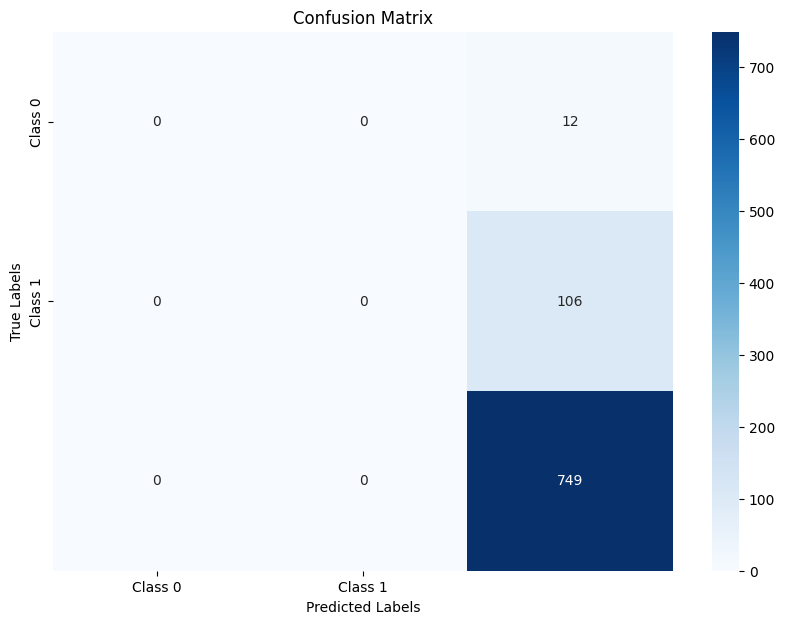

In [378]:
#Final Evaluation

# Print accuracy
print("Accuracy:", accuracy_score(ytest, ypred))

# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(ytest, ypred, zero_division=0))  # Set zero_division to 0

# Generate and plot confusion matrix
cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 🎯 Predict